In [1]:
%matplotlib inline

In [2]:
#Set model to freely swim
use_free_move = False

# Importing Libraries

Importing libraries for script

In [3]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.output_points_3d import PointsOutput3D
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi,sin
import sympy
from sympy import sqrt
import math
import scipy.optimize
from matplotlib import animation, rc
from IPython.display import HTML


system = System()
pynamics.set_system(__name__,system)

# Constants of System

In this block of code we are defining all the constants of our system that we will use for our simulation

In [4]:
#Defining Constants of System
seg_len = 0.05    #segment length
seg_mass = 0.001 #segment mass 
seg_h = 0.03 #segment height
seg_th = 0.001 #segment thickness

#Set segment lengths
lA = Constant(seg_len,'lA',system)
lB = Constant(seg_len,'lB',system)
lC = Constant(seg_len,'lC',system)
lD = Constant(seg_len,'lD',system)
lE = Constant(seg_len,'lE',system)
lF = Constant(seg_len,'lF',system)
lG = Constant(seg_len,'tail',system)
lP = Constant(seg_len*5.5,'lP',system) #Constrained length

#Set masses
mA = Constant(seg_mass,'mA',system)
mB = Constant(seg_mass,'mB',system)
mC = Constant(seg_mass,'mC',system)
mD = Constant(seg_mass,'mD',system)
mE = Constant(seg_mass,'mE',system)
mF = Constant(seg_mass,'mF',system)
mG = Constant(seg_mass,'mG',system)

b = Constant(2.148e-6,'b',system)
k = Constant(1.6e-4,'k',system)
area = Constant(seg_len*seg_h,'area',system)
rho = Constant(998,'rho',system)

freq = Constant(.5,'freq',system)
amp = Constant(40*pi/180,'amp',system)
torque = Constant(.7,'torque',system)

Ixx = Constant(1/12*seg_mass*(seg_h**2 + seg_th**2),'Ixx',system)
Iyy = Constant(1/12*seg_mass*(seg_h**2 + seg_len**2),'Iyy',system)
Izz = Constant(1/12*seg_mass*(seg_len**2 + seg_th**2),'Izz',system)
Ixx_G = Constant(1/12*seg_mass*(seg_h*2 + seg_th**2),'Ixx_G',system)
Iyy_G = Constant(1/12*seg_mass*(seg_h**2 + seg_len**2),'Iyy_G',system)
Izz_G = Constant(1/12*seg_mass*(seg_len**2 + seg_th**2),'Izz_G',system)


In [5]:
#Set integration tolerance
tol = 1e-12

In [6]:
#Set simulation run time
fps = 30
tinitial = 0
tfinal = 5
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [7]:
#Define derivatives of frames
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qG,qG_d,qG_dd = Differentiable('qG',system)

if use_free_move:
    x,x_d,x_dd = Differentiable('x',system)
    y,y_d,y_dd = Differentiable('y',system)

In [8]:
#set initial conditions
initialvalues = {}
initialvalues[qA]=40*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=20*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=10*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=0*pi/180
initialvalues[qD_d]=0*pi/180
initialvalues[qE]=-10*pi/180
initialvalues[qE_d]=0*pi/180
initialvalues[qF]=-40*pi/180
initialvalues[qF_d]=0*pi/180
initialvalues[qG]=-40*pi/180
initialvalues[qG_d]=0*pi/180

if use_free_move:
    initialvalues[x]=0*pi/180
    initialvalues[x_d]=0*pi/180
    initialvalues[y]=0*pi/180
    initialvalues[y_d]=0*pi/180

statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [9]:
#Frames
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
D = Frame('D',system)
E = Frame('E',system)
F = Frame('F',system)
G = Frame('G',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(N,[0,0,1],qB,system)
C.rotate_fixed_axis(N,[0,0,1],qC,system)
D.rotate_fixed_axis(N,[0,0,1],qD,system)
E.rotate_fixed_axis(N,[0,0,1],qE,system)
F.rotate_fixed_axis(N,[0,0,1],qF,system)
G.rotate_fixed_axis(N,[0,0,1],qG,system)

# Defining Vectors

In this section of code we are defining all the position and center of mass vecotors. Additionally we are calculating angular velocity of each frame and the respective linear velocities at the center of mass. We also build each body of the system in this section.

In [10]:
#Vectors
if use_free_move:
    pNA=x*N.x + y*N.y + 0*N.z
    pP = lP*N.x + pNA
else:
    pNA=0*N.x + 0*N.y + 0*N.z
    pP = lP*N.x
    
pAB= pNA + lA*A.x
pBC = pAB + lB*B.x
pCD = pBC + lC*C.x
pDE = pCD + lD*D.x
pEF = pDE + lE*E.x
pFG = pEF + lF*F.x
pGtip = pFG + lG*G.x

#Center of Mass
pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x
pDcm=pCD+lD/2*D.x
pEcm=pDE+lE/2*E.x
pFcm=pEF+lF/2*F.x
pGcm=pFG+lG/2*G.x

#Angular Velocity
wNA = N.get_w_to(A)
wAB = A.get_w_to(B) 
wBC = B.get_w_to(C)
wCD = C.get_w_to(D) 
wDE = D.get_w_to(E)
wEF = E.get_w_to(F)
wFG = F.get_w_to(G)

#Velocities 
vA=pAcm.time_derivative()
vB=pBcm.time_derivative()
vC=pCcm.time_derivative()
vD=pDcm.time_derivative()
vE=pEcm.time_derivative()
vF=pFcm.time_derivative()
vGtip=pGtip.time_derivative()

#Interia and Bodys
IA = Dyadic.build(A,Ixx,Iyy,Izz)
IB = Dyadic.build(B,Ixx,Iyy,Izz)
IC = Dyadic.build(C,Ixx,Iyy,Izz)
ID = Dyadic.build(D,Ixx,Iyy,Izz)
IE = Dyadic.build(E,Ixx,Iyy,Izz)
IF = Dyadic.build(F,Ixx,Iyy,Izz)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyE = Body('BodyE',E,pEcm,mE,IE,system)
BodyF = Body('BodyF',F,pFcm,mF,IF,system)
BodyG = Body('BodyG',G,pGcm,mG,IG,system)

# Adding Forces

In this section of code we are adding the aerodynamic, spring, and damping forces in the system. The damping and spring values will be calculated experimentally.

In [11]:
#Forces
#system.addforce(-torque*sympy.sin(freq*2*pi*system.t)*A.z,wNA) #setting motor parameter

#Aerodynamic Forces
f_aero_Ay = rho * vA.length()*(vA.dot(A.y)) * area * A.y
f_aero_By = rho * vB.length()*(vB.dot(B.y)) * area * B.y
f_aero_Cy = rho * vC.length()*(vC.dot(C.y)) * area * C.y
f_aero_Dy = rho * vD.length()*(vD.dot(D.y)) * area * D.y
f_aero_Ey = rho * vE.length()*(vE.dot(E.y)) * area * E.y
f_aero_Fy = rho * vF.length()*(vF.dot(F.y)) * area * F.y
f_aero_Gy = rho * vGtip.length()*(vGtip.dot(G.y)) * area * G.y

system.addforce(-f_aero_Ay,vA)
system.addforce(-f_aero_By,vB)
system.addforce(-f_aero_Cy,vC)
system.addforce(-f_aero_Dy,vD)
system.addforce(-f_aero_Ey,vE)
system.addforce(-f_aero_Fy,vF)
system.addforce(-f_aero_Gy,vGtip)

#Damping Forces
#system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)
system.addforce(-b*wDE,wDE)
system.addforce(-b*wEF,wEF)
system.addforce(-b*wFG,wFG)

#Spring Force (Torsion)
#system.add_spring_force1(k,(qA)*N.z,wNA) 
system.add_spring_force1(k,(qB-qA)*N.z,wAB)
system.add_spring_force1(k,(qC-qB)*N.z,wBC)
system.add_spring_force1(k,(qD-qC)*N.z,wCD) 
system.add_spring_force1(k,(qE-qD)*N.z,wDE)
system.add_spring_force1(k,(qF-qE)*N.z,wEF)
system.add_spring_force1(k,(qG-qF)*N.z,wFG)

(<pynamics.force.Force at 0x1a2f7e10e80>,
 <pynamics.spring.Spring at 0x1a2f7e10e20>)

# Initial Condition

Solving for initial condition constraints and using scipy to solve for initial states and setting initial states to system initial states.

In [12]:
#Constraints for initial condition

eq = []

eq.append(pFG-pP)
    
eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))

#system.add_constraint(KinematicConstraint(eq_scalar))

In [13]:
#Solve for Intial Conditions
if use_free_move:
    qi = [qA,x,y]
else:  
    qi = [qA]

qd = [qB,qC,qD,qE,qF,qG]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]
defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]

error = (numpy.array(eq_scalar_c)**2).sum()

f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
    
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

2022-04-12 16:07:12,103 - pynamics.output - INFO - calculating outputs
2022-04-12 16:07:12,111 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

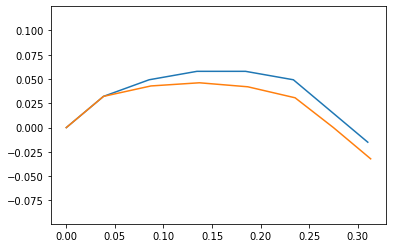

In [14]:
#Plot Initial State
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFG,pGtip]
points_output = PointsOutput(points, constant_values=system.constant_values)
points_output.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points_output.plot_time()

# Setting Dynamic Constraints

Solving for dynamic constraints of system to run simulation.

In [15]:
#Adding Dynamic Constraints

#Position of motor limits
pos = amp*sympy.cos(freq*2*pi*system.t)

eq = []

eq.append(pFG-pP)
eq.append(pos*N.z-qA*A.z)

eq_d = []
eq_d = [item.time_derivative() for item in eq]

eq_dd = []
eq_dd = [item.time_derivative() for item in eq_d]

eq_dd_scalar = []
eq_dd_scalar.append(eq_dd[0].dot(N.x))
eq_dd_scalar.append(eq_dd[0].dot(N.y))
eq_dd_scalar.append(eq_dd[1].dot(N.z))

system.add_constraint(AccelerationConstraint(eq_dd_scalar))

# Solving for Simulation

Code to run simulation and plot motion, states, and total energy in system.

2022-04-12 16:07:12,398 - pynamics.system - INFO - getting dynamic equations
2022-04-12 16:07:13,950 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-12 16:07:19,254 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-12 16:07:20,023 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-12 16:07:20,023 - pynamics.system - INFO - calculating function for lambdas
2022-04-12 16:07:20,048 - pynamics.integration - INFO - beginning integration
2022-04-12 16:07:20,048 - pynamics.system - INFO - integration at time 0000.00
2022-04-12 16:07:26,393 - pynamics.system - INFO - integration at time 0000.37
2022-04-12 16:07:32,476 - pynamics.system - INFO - integration at time 0000.64
2022-04-12 16:07:38,881 - pynamics.system - INFO - integration at time 0000.96
2022-04-12 16:07:45,083 - pynamics.system - INFO - integration at time 0001.08
2022-04-12 16:07:51,310 - pynamics.system - INFO - integration at time 0001.23
2022-04-12 16:07:57

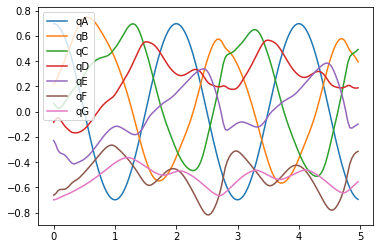

In [16]:
#Solve model and plot angles

f,ma = system.getdynamics()

func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':system.constant_values},))


plt.figure()
artists = plt.plot(t,states[:,:7])
plt.legend(artists,['qA','qB','qC','qD','qE','qF','qG'])

2022-04-12 16:08:53,577 - pynamics.output - INFO - calculating outputs
2022-04-12 16:08:53,585 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

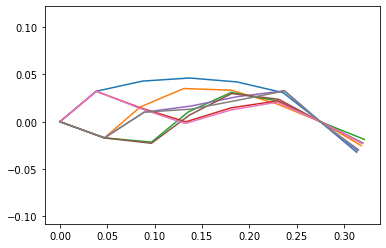

In [17]:
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFG,pGtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

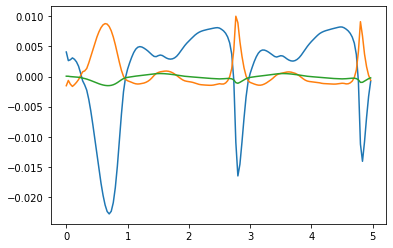

In [18]:
#Constraint Forces

lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
plt.figure()
plt.plot(t, lambda2)

2022-04-12 16:08:54,852 - pynamics.output - INFO - calculating outputs
2022-04-12 16:08:54,884 - pynamics.output - INFO - done calculating outputs


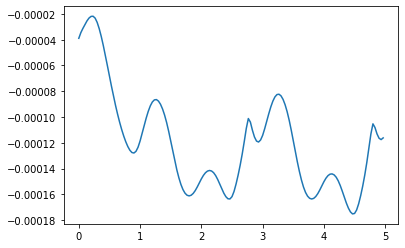

In [19]:
#Energy Plot

KE = system.get_KE()
PE = system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time(t)

Text(0, 0.5, 'Position Y (m)')

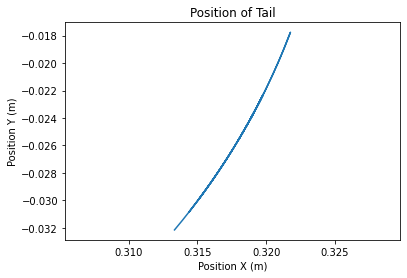

In [20]:
#Plotting Motion of Tail

plt.plot(y[:,7,0],y[:,7,1])
plt.axis('equal')
plt.title('Position of Tail')
plt.xlabel('Position X (m)')
plt.ylabel('Position Y (m)')

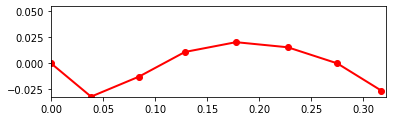

In [21]:
if use_free_move:
    points_output.animate(fps = fps,movie_name = 'dynamics_free_swimming_V2.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
else:
    points_output.animate(fps = fps,movie_name = 'dynamics_V2.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
    
HTML(points_output.anim.to_html5_video())